In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile
import czifile
from csbdeep.utils import normalize
from tqdm import tqdm
from scipy.ndimage import zoom 
import argparse
import csv
import glob
import PIL
from PIL import Image
import torchvision
from fastprogress import *
from skimage.measure import compare_ssim, compare_psnr
from pdb import set_trace

In [42]:
def slice_process(x1, x2, y):
    if len(x1.shape) == 3: x1 = x1[:,:,0]
    if len(x2.shape) == 3: x2 = x2[:,:,0]
    if len(y.shape) == 3: y = y[:,:,0]

    # a scaled and shifted version of pred and bilinear
    x1 = 2*x1 + 100
    x2 = 2*x2 + 100
    x1 = x1/255.0
    x2 = x2/255.0    

    # normalize/scale images
    (y_norm1, x1_norm) = norm_minmse(y, x1)	
    (y_norm2, x2_norm) = norm_minmse(y, x2)
    
    # calulate psnr and ssim of the normalized/scaled images
    psnr1 = compare_psnr(*(y_norm1, x1_norm), data_range = 1.)
    psnr2 = compare_psnr(*(y_norm2, x2_norm), data_range = 1.)
    ssim1 = compare_ssim(*(y_norm1, x1_norm), data_range = 1.)
    ssim2 = compare_ssim(*(y_norm2, x2_norm), data_range = 1.)
    return psnr1, ssim1, psnr2, ssim2, y_norm1, x1_norm, y_norm2, x2_norm   

def slice_process_255(x1, x2, y):
    if len(x1.shape) == 3: x1 = x1[:,:,0]
    if len(x2.shape) == 3: x2 = x2[:,:,0]
    if len(y.shape) == 3: y = y[:,:,0]

    # calulate psnr and ssim of the normalized/scaled images
    dr = 255.0
    psnr1 = compare_psnr(*(y, x1), data_range = dr)
    psnr2 = compare_psnr(*(y, x2), data_range = dr)
    ssim1 = compare_ssim(*(y, x1), data_range = dr)
    ssim2 = compare_ssim(*(y, x2), data_range = dr)
    return psnr1, ssim1, psnr2, ssim2, y, x1, y, x2  

In [43]:
def norm_minmse(gt, x, normalize_gt=True):
    """
    normalizes and affinely scales an image pair such that the MSE is minimized  
     
    Parameters
    ----------
    gt: ndarray
        the ground truth image      
    x: ndarray
        the image that will be affinely scaled 
    normalize_gt: bool
        set to True of gt image should be normalized (default)
    Returns
    -------
    gt_scaled, x_scaled 
    """
    if normalize_gt:
        gt = normalize(gt, 0.1, 99.9, clip=False).astype(np.float32, copy = False)
    x = x.astype(np.float32, copy=False) - np.mean(x)
    gt = gt.astype(np.float32, copy=False) - np.mean(gt)
    scale = np.cov(x.flatten(), gt.flatten())[0, 1] / np.var(x.flatten())
    return gt, scale * x

def save_stats(stats, save_dir):
    with open(save_dir, 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(stats)
    csvFile.close() 
 
  
def stack_process(pred, bilinear, gt, offset_frames=0):
    stack_pred = PIL.Image.open(pred)
    stack_bilinear = PIL.Image.open(bilinear)
    stack_gt  = PIL.Image.open(gt)

    stem = Path(pred).stem
    frames = stack_pred.n_frames
    stack_psnr = []
    stack_lpsnr = []
    stack_ssim = []
    stack_lssim = []
    stack_name = []
    #y_norm1s = []
    #x1_norms = []
    #y_norm2s = []
    #x2_norms = []

    for i in range(frames):
        stack_pred.seek(i)
        stack_bilinear.seek(i) if frames == 1 else stack_bilinear.seek(i+offset_frames)  
        stack_gt.seek(i) if frames == 1 else stack_gt.seek(i+offset_frames)

        x1 = np.array(stack_pred).astype(np.float32)
        x2 = np.array(stack_bilinear).astype(np.float32)
        y = np.array(stack_gt).astype(np.float32)
        psnr, ssim, l_psnr, l_ssim, y_norm1, x1_norm, y_norm2, x2_norm = slice_process(x1, x2, y)

        stack_psnr.append(psnr)
        stack_lpsnr.append(l_psnr)       
        stack_ssim.append(ssim)
        stack_lssim.append(l_ssim)  
        stack_name.append(f'{stem}_z{i}.tif')

        #y_norm1s.append(np.array(y_norm1).copy())
        #x1_norms.append(np.array(x1_norm).copy())
        #y_norm2s.append(np.array(y_norm2).copy())
        #x2_norms.append(np.array(x2_norm).copy())


    #tifffile.imsave(str(exp_dir/f"{stem}_GTnormtopred.tif"), np.stack(y_norm1s).astype(np.float32))
    #tifffile.imsave(str(exp_dir/f"{stem}_prednorm.tif"), np.stack(x1_norms).astype(np.float32))
    #tifffile.imsave(str(exp_dir/f"{stem}_GTnormtobilinear.tif"), np.stack(y_norm2s).astype(np.float32))
    #tifffile.imsave(str(exp_dir/f"{stem}_bilinearnorm.tif"), np.stack(x2_norms).astype(np.float32))
    return stack_name, stack_psnr,stack_ssim,stack_lpsnr,stack_lssim

def metric_gen(predset, testset, bilinset, offset_frames):
    save_dir = f'stats.csv'

    pred_dir = Path(predset)
    bilinear_dir = Path(bilinset)
    gt_dir = Path(testset)

    pred_list = list(pred_dir.glob(f'*.tif'))
    bilinear_list = list(bilinear_dir.glob(f'*.tif'))
    gt_list = list(gt_dir.glob(f'*.tif'))

    pred_list.sort()
    bilinear_list.sort()
    gt_list.sort()

    names = ['name']
    ssims = ['ssims']
    l_ssims = ['l_ssims']
    psnrs = ['psnrs']
    l_psnrs = ['l_psnrs']

    for p, l, t in progress_bar(list(zip(pred_list, bilinear_list, gt_list))):
        print(f'pred: {p}')
        print(f'bilinear: {l}')
        print(f'gt: {t}')
        print(f'offset_frame: {offset_frames}')
        stack_name,stack_psnr,stack_ssim,stack_lpsnr,stack_lssim = stack_process(p,l,t,offset_frames)

        names = np.concatenate((names, stack_name), out=None)
        psnrs = np.concatenate((psnrs, stack_psnr), out=None)
        l_psnrs = np.concatenate((l_psnrs, stack_lpsnr), out=None)    
        ssims = np.concatenate((ssims, stack_ssim), out=None)
        l_ssims = np.concatenate((l_ssims, stack_lssim), out=None)
    stats = zip(names, ssims, l_ssims, psnrs, l_psnrs)
    return list(stats)

In [44]:
testset = Path("/home/alaa/Dropbox/BPHO Staff/USF/EM/testing/HR/real-world_SEM/")
predset = Path("/home/alaa/Dropbox/BPHO Staff/USF/EM/testing/emsynth_005_unet/real-world_SEM/")
bilinset = Path("/home/alaa/Dropbox/BPHO Staff/USF/EM/testing/LR-Bilinear/real-world_SEM/")

In [ ]:
result_list = metric_gen(predset, testset, bilinset, 0)

pred: /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/emsynth_005_unet/real-world_SEM/realword_SEM_test_emsynth_005_unet_5_01.tif
bilinear: /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/LR-Bilinear/real-world_SEM/realword_SEM_test_bilinear_01.tif
gt: /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/HR/real-world_SEM/realword_SEM_test_hr_01.tif
offset_frame: 0


/home/rusl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/home/rusl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/home/rusl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/home/rusl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


pred: /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/emsynth_005_unet/real-world_SEM/realword_SEM_test_emsynth_005_unet_5_02.tif
bilinear: /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/LR-Bilinear/real-world_SEM/realword_SEM_test_bilinear_02.tif
gt: /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/HR/real-world_SEM/realword_SEM_test_hr_02.tif
offset_frame: 0
pred: /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/emsynth_005_unet/real-world_SEM/realword_SEM_test_emsynth_005_unet_5_03.tif
bilinear: /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/LR-Bilinear/real-world_SEM/realword_SEM_test_bilinear_03.tif
gt: /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/HR/real-world_SEM/realword_SEM_test_hr_03.tif
offset_frame: 0
pred: /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/emsynth_005_unet/real-world_SEM/realword_SEM_test_emsynth_005_unet_5_04.tif
bilinear: /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/LR-Bilinear/real-world_SEM/realword_SEM_test_bilinear_04.tif
gt: /home/alaa/Dropbox/BPHO Staff/USF/EM/testing/

In [22]:
result_list_255 = metric_gen(predset, testset, bilinset, 0, compare_func=slice_process_255)

/home/rusl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/home/rusl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/home/rusl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/home/rusl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


## Line by line

In [8]:
pred_dir = Path(predset)
bilinear_dir = Path(bilinset)
gt_dir = Path(testset)
pred_list = list(pred_dir.glob(f'*.tif'))
bilinear_list = list(bilinear_dir.glob(f'*.tif'))
gt_list = list(gt_dir.glob(f'*.tif'))
pred_list.sort()
bilinear_list.sort()
gt_list.sort()

In [9]:
# Assert images match up
len(pred_list), len(bilinear_list), len(gt_list)

(42, 42, 42)

In [10]:
idx = -1
pred, bilinear, gt = pred_list[idx], bilinear_list[idx], gt_list[idx]

In [11]:
stack_pred = PIL.Image.open(pred)
stack_bilinear = PIL.Image.open(bilinear)
stack_gt  = PIL.Image.open(gt)

In [12]:
x1 = np.array(stack_pred).astype(np.float32)[...,0]
x2 = np.array(stack_bilinear).astype(np.float32)
y = np.array(stack_gt).astype(np.float32)

In [15]:
# Assert shapes
x1.shape, x2.shape, y.shape

((500, 500), (500, 500), (500, 500))

In [19]:
# Naive comparison - Using 0,255
# PSNR looks better
compare_psnr(x1, y, data_range=255), compare_ssim(x1, y, data_range=255)

(24.66936633731013, 0.4869086875084407)

In [20]:

def norm_minmse(gt, x, normalize_gt=True):
    if normalize_gt:
        gt = normalize(gt, 0.1, 99.9, clip=False).astype(np.float32, copy = False)
    x = x.astype(np.float32, copy=False) - np.mean(x)
    gt = gt.astype(np.float32, copy=False) - np.mean(gt)
    scale = np.cov(x.flatten(), gt.flatten())[0, 1] / np.var(x.flatten())
    return gt, scale * x

In [21]:
x1_n = 2*x1 + 100
# x1_n = x1
# x2_n = 2*x2 + 100
(y_norm1, x1_norm) = norm_minmse(y, x1_n)
# (y_norm2, x2_norm) = norm_minmse(y, x2_n)

x1_norm.min(), x1_norm.max(), y_norm1.min(), y_norm1.max()

(-0.510406, 0.44000933, -0.5385153, 0.69282806)

## WHY IS min and max -0.5 and 0.44???
## SSIM requires a range of 0,1

In [22]:
x1_n = 2*x1 + 100
# x1_n = x1
# x2_n = 2*x2 + 100
(y_norm1, x1_norm) = norm_minmse(y, x1_n)
# (y_norm2, x2_norm) = norm_minmse(y, x2_n)


psnr1 = compare_psnr(y_norm1, x1_norm, data_range = 1.)
# psnr2 = compare_psnr(y_norm2, x2_norm, data_range = 1.)
ssim1 = compare_ssim(y_norm1, x1_norm, data_range = 1.)
# ssim2 = compare_ssim(y_norm2, x2_norm, data_range = 1.)

psnr1, ssim1

(19.25543489483789, 0.22137718493790587)

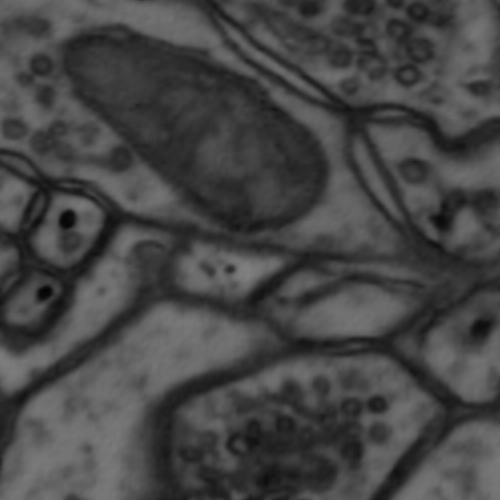

In [23]:
PIL.Image.open(pred_list[idx])

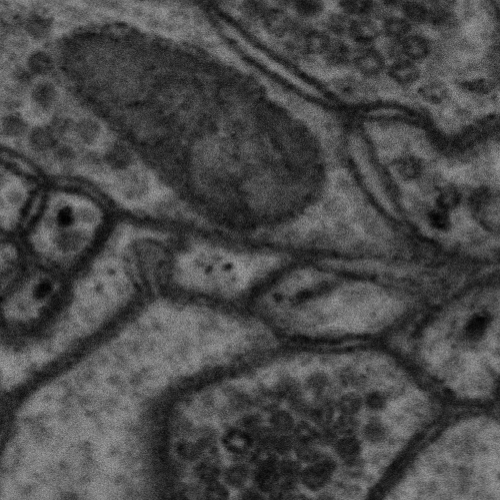

In [24]:
PIL.Image.open(gt_list[idx])

In [25]:
pred_list[0]

PosixPath('/home/alaa/Dropbox/BPHO Staff/USF/EM/testing/emsynth_005_unet/real-world_SEM/realword_SEM_test_emsynth_005_unet_5_01.tif')